<a href="https://colab.research.google.com/github/Samarth1337/Photo_Gallery_Organizer/blob/main/Photo_Gallery_Organizer_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Use a trained Autoencoder model to extract features from the images
> #### 1.1 Prepare data
> #### 1.2 Create autoencoder model and train it
> #### 1.3 Extract features from images using the trained encoder
### 2. Cluster images on the basis of extracted features
> #### 2.1 Prepare clustering algorithm
> #### 2.2 Get clusters from the features
> #### 2.3 Visualize results

### 1. Use a trained Autoencoder model to extract features from the images

#### 1.1 Prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/My\ Drive/MNIST.zip

Archive:  /content/drive/My Drive/MNIST.zip
replace MNIST/images/10017.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
%matplotlib inline
%tensorflow_version 1.x

import os
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Input, Conv2D

from skimage.io import imread

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

In [ ]:
seed = 128
rng = np.random.RandomState(seed)

In [ ]:
# define directory path
data_dir = os.path.join(os.path.abspath('.'), 'MNIST')

In [ ]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))

train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


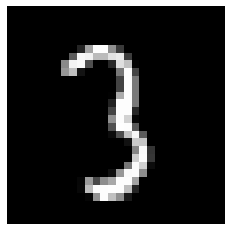

In [ ]:
# plot sample image
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'images', img_name)

img = imread(filepath, as_gray=True)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img.shape

(28, 28)

In [ ]:
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'images', img_name)
    img = imread(image_path, as_gray=True)
    temp.append(img)

train_x = np.stack(temp)
train_x = train_x.reshape(-1, 784).astype('float32')

In [ ]:
train_x.shape

(49000, 784)

In [ ]:
train_x.min(), train_x.max()

(0.0, 1.0)

In [ ]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]

#### 1.2 Create autoencoder model and train it

![alt text](https://drive.google.com/uc?id=1duzhaXwCuvZf4gs03pJNcJPEYUxT2y_8)

In [ ]:
# define architecture of autoencoder

## input placeholder
input_img = Input(shape=(784, ))

## "encoded" is the encoded representation of the input
encoded = Dense(2000, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(100, activation='relu')(encoded)
encoded = Dense(10, activation='linear')(encoded)

## "decoded" is the lossy reconstruction of the input
decoded = Dense(100, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

## this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## this model maps an input to its features
encoder = Model(input_img, encoded)

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              1570000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_3 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               5050

In [ ]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              1570000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_3 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 2,621,610
Trainable params: 2,621,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
train_history = autoencoder.fit(train_x, train_x, epochs=100, batch_size=256, validation_data=(val_x, val_x))




Train on 34300 samples, validate on 14700 samples
Epoch 1/100





34300/34300 [==============================] - 2s 59us/step - loss: 0.0607 - val_loss: 0.0336
Epoch 2/100
34300/34300 [==============================] - 1s 27us/step - loss: 0.0288 - val_loss: 0.0254
Epoch 3/100
34300/34300 [==============================] - 1s 27us/step - loss: 0.0231 - val_loss: 0.0214
Epoch 4/100
34300/34300 [==============================] - 1s 27us/step - loss: 0.0202 - val_loss: 0.0197
Epoch 5/100
34300/34300 [==============================] - 1s 26us/step - loss: 0.0187 - val_loss: 0.0185
Epoch 6/100
34300/34300 [==============================] - 1s 26us/step - loss: 0.0176 - val_loss: 0.0178
Epoch 7/100
34300/34300 [==============================] - 1s 26us/step - loss: 0.0168 - val_loss: 0.0171
Epoch 8/100
34300/34300 [==============================] - 1s 27us/step - loss: 0.0162 - val_loss: 0.0165
Epoch 9/100
34300/34300 [==============================] - 1s 26us/step - loss: 0.0157 - val_l

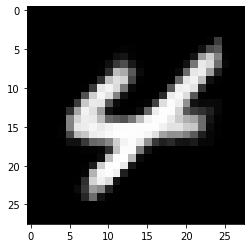

In [ ]:
temp = autoencoder.predict(train_x)
plt.imshow(temp[0].reshape((28, 28)), cmap='gray')

In [ ]:
temp = encoder.predict(train_x)
temp[0]

array([ 16.117693 ,  -7.966588 , -18.996788 ,  -5.651637 , -20.761293 ,
        -2.2775679,  -1.9109703,  -6.4678216, -14.582864 ,   6.706299 ],
      dtype=float32)

#### 1.3 Extract features from images using the trained encoder

In [ ]:
# get features from encoder
pred_auto_train = encoder.predict(train_x)
pred_auto = encoder.predict(val_x)


### 2. Cluster images on the basis of extracted features

#### 2.1 Prepare clustering algorithm

In [ ]:
# train a kmeans clustering model to categorize the features of images

## define kmeans model
km = KMeans(n_jobs=-1, n_clusters=10)

#### 2.2 Get clusters from the features


In [ ]:
## train kmeans model on features extracted from training data
km.fit(pred_auto_train)

## get predictions from kmeans model on features extracted from validation data
pred = km.predict(pred_auto)

#### 2.3 Visualize results

This image belongs to Cluster 2


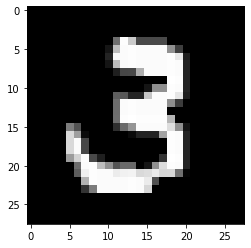

In [ ]:
# check the output of kmeans model
index = rng.choice(range(len(val_x)))

print("This image belongs to Cluster " + str(pred[index]))
plt.imshow(val_x[index].reshape((28, 28)), cmap='gray')
plt.show()

In [ ]:
# get actual classes
train_y = train.label.values
train_y, val_y = train_y[:split_size], train_y[split_size:]

# compare clusters with actual classes
temp = pd.DataFrame({"val_y":val_y, "cluster_name":pred})
temp[temp.cluster_name == 1].head()

,val_y,cluster_name
15,7,1
20,9,1
24,7,1
49,7,1
50,7,1


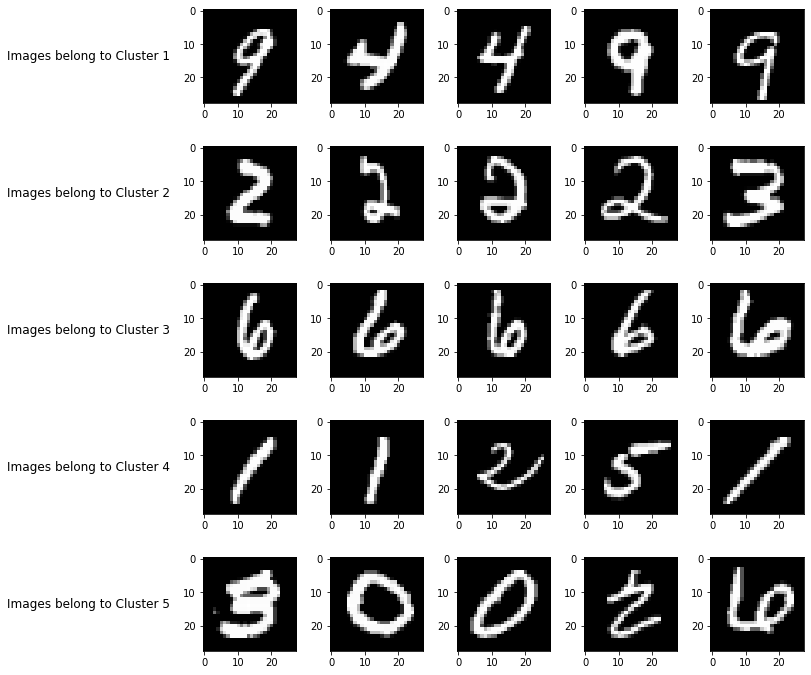

In [ ]:
# visualize multiple images of cluster
## create plot
fig,axes = plt.subplots(nrows=5,ncols=5,figsize=(10,10))


## set row name on the basis of clusters
rows = ['Images belong to Cluster {}'.format(row) for row in ['1', '2', '3', '4', '5']]
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

## set images in subplots
for i in range(5):
  temp2 = temp[temp.cluster_name == i].head() 
  for j, img in enumerate(val_x[temp2.index.values]):
    img = img.reshape((28, 28))
    axes[i][j].imshow(img, cmap='gray')

## adjust plot with respect to the column title
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

## show plot
plt.show()

In [ ]:
# print score of overall model
normalized_mutual_info_score(pred, val_y)

0.6496137182083237